In [1]:
!pip install pandas==0.25.3
 
import pandas as pd
from pandas_profiling import ProfileReport
print(pd.__version__)

     |████████████████████████████████| 10.4MB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
  Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5


1.0.5


# **クラスタリング(k-means法)**
　今回はk-means法を使用して、今あるデータから特徴量を生成し、それを別の機械学習手法に使うスタッキングというアンサンブル手法を行ってみたいと思います。参考にしたのは、「機械学習のための特徴量エンジニアリング(O'Reilly Japan)」です。
## **スタッキング**
　スタッキングとは、学習段階を2つ以上に分けて学習を行う手法になります。1段階目で、何らかのモデルを用いて入力データの学習と予測(特徴量生成)を行います。2段階目で前の段階の予測結果(特徴量)を使用して学習と実際の予測値を算出することが出来ます。
 
今回は、1段階目でk-means法を使用して特徴量を生成し、2段階目で、k-means法以外の方法で実際の予測値を算出する方法を紹介します。
 
参照：「図解即戦力　機械学習&ディープラーニングのしくみと技術がこれ一冊でしっかりわかる教科書」
 
## **使用するデータセット**
　今回、少し異なるデータを使用してみようかと思い、別のデータを選んでみました。
 
　今回は使うのは、https://www.kaggle.com/uciml/glass
のガラスのタイプ(多クラス)分類です。とても分かりやすいデータセットでした。
 
## **流れ**
流れとして以下の手順で進んでいきます。
* Grassデータセット
  * grassデータについて見てみます
* ベースラインの構築(ランダムフォレスト)
  * 変数の選択
  * 大体どのくらいの分類精度が出せるか
* k-meansによる特徴用生成
  * 今ある特徴量からk-meansによって新しい特徴量を生成
* 複数のモデルで評価
  * 新しく生成した特徴量を使用してモデルの評価を行う
* おまけ
  * Glassデータで分かりにくかったのでTitanicでも行ってみました

## **Glassデータセット可視化**
　pandasとpandas-profilingによってデータの概観を把握します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

df = pd.read_csv('datasets_738_1370_glass.csv')

# pandas-profilingの結果をhtml形式で出力
# profile = ProfileReport(df)
# profile.to_file(outputfile="myoutputfile.html")

df
# refractive index(RI)：屈折率

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


## **ベースライン(ランダムフォレスト)の構築と評価**
　主に特徴量の選択・大体どのくらいの精度がでるかなどを把握します。

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# RFの訓練・予測をloop_count分行って正解率の平均を返す
def rf_accuracy(X, y, loop_count=20, graph=False):
  total = 0
  for i in range(loop_count):
    # 検証データを20%にする
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # ランダムフォレスト
    rf = RandomForestClassifier()

    # 分類器を訓練
    model = rf.fit(X_train, y_train)

    # 予測
    y_pre = model.predict(X_test)

    # print(accuracy_score(y_pre, y_test))
    total += accuracy_score(y_pre, y_test)

  if graph:
    # 特徴量重要性を計算
    importances = model.feature_importances_

    # 特徴量重要性を降順にソート: argsortで昇順に並べ[::-1]で反転
    indices = np.argsort(importances)[::-1]

    # 特徴量の名前をソートした順に並び変え
    names = [X.columns[i] for i in indices]

    # プロットを作成
    plt.figure()

    # プロットのタイトルを作成
    plt.title("Feature Importance")

    # 棒グラフを追加
    plt.bar(range(X.shape[1]), importances[indices])

    # X軸に特徴量の名前を追加：rotation:ラベルを90度回転
    plt.xticks(range(X.shape[1]), names, rotation=90)

    # プロットを表示
    plt.show()

  return total / (i + 1)

* Pandas-profilingから分かること
  * RIとCaの相関が少々高め
  * BaとFeが0に偏りすぎている  
* ランダムフォレスト重要度
  * 分類の際に重要だった変数が分かる

　重要度の低い特徴量を減らしていくと、正解率が上がっていきます。ランダムフォレスト10回分の平均をとっているので、平均して正解率が高くなっていることが分かり、良い特徴量が選べていることが分かります。


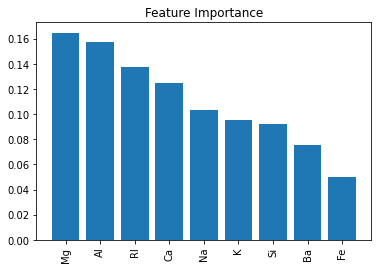

mean: 0.7848837209302323
mean: 0.9651162790697676
mean: 0.975581395348837
mean: 0.991860465116279


In [5]:
# 2列目から最後-1列目まで
X = df.iloc[:, :-1]
y = df["Type"]

# 全変数使用
print("mean:",rf_accuracy(X, y, graph=True))

# # Ba, Feを削除
X = df.drop(columns=["Ba", "Fe"])
print("mean:",rf_accuracy(X, y))

# # Fe, Ba, Caを削除
X = df.drop(columns=["Ca", "Ba", "Fe"])
print("mean:",rf_accuracy(X, y))

X = df.drop(columns=["K", "Ca", "Ba", "Fe", "Si", "Na"])
print("mean:",rf_accuracy(X, y))

## k-meansによる特徴量生成
　k-means法によって、今ある特徴量から新しい特徴量を生成します。

### k-meansによる特徴量生成クラスの定義
　こちらのクラスは「機械学習のための特徴量エンジニアリング(O'Reilly Japan)」の本をコピーしたものです。
* やること
  * k-means法により、予め入力データをいくつかのクラスに分類出来ないかを考える
* 手順
  * 入力データにターゲット変数を加えたものに対して、k-meansを実行し、`self.k`で指定したクラスタの数分の中心を見つけます。  
  これにより、より正解に近い分布でのクラスタの中心の値が求まります。
  * 次に、k-meansの開始位置を前の手順で求めたクラスタの中心の値で初期化し、ターゲット変数を除いた入力データを`self.k`で指定したクラスタ数に分けます。  
  ここで、ターゲット変数を除いているので、前の手順より多少不正確なクラスタ群にばらけます。
  * `transform`メソッドにより、入力したデータが前の手順で求めたクラスタのどこに属するかを求め、それを特徴量とします。

* 利点
  * 空間内でのデータの広がりを特徴量として考えられる
  * Glassのタイプの数より多いクラスタ数に分割して、特徴量に加えられる

In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

class KMeansFeaturizer:
    """
    数値データをk-meansのクラスタIDに変換します。
    
    この変換器は入力データに対してk-meansを実行し、各データポイントを最も近い
    クラスタのIDに変換します。ターゲット変数yが存在する場合、クラス分類の境界を
    より重視したクラスタリングの結果を得るために、ターゲット変数をスケーリングして
    入力データに含めてk-meansに渡します。
    """
    
    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder(categories='auto').fit(np.array(range(k)).reshape(-1,1))

    def fit(self, X, y=None):
        """
        入力データに対しk-meansを実行し、各クラスタの中心を見つけます。
        """
        if y is None:
            # ターゲット変数がない場合、ふつうのk-meansを実行します。
            km_model = KMeans(n_clusters=self.k, random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # ターゲット変数がある場合。スケーリングして入力データに含めます。
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # ターゲットを組み入れたデータで事前学習するためのk-meansモデルを構築します。
        km_model_pretrain = KMeans(n_clusters=self.k, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # ターゲット変数の情報を除いて元の空間におけるクラスタを得るために
        # k-meansを再度実行します。事前学習で見つけたクラスタの中心を
        # 使って初期化し、クラスタの割り当てと中心の再計算を1回にします。
        r = X.shape[1]
        km_model = KMeans(n_clusters=self.k, init=km_model_pretrain.cluster_centers_[:,:r], n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
    
    def transform(self, X, y=None):
        """
        入力データポイントに最も近いクラスタのIDを返します。
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

### 訓練・予測用関数の定義
　LogisticRegression・kNN・RBF SVM・RandomForest・Boosted Treesでloop_count回数分繰り返し、平均の精度を返す。複数の予測の平均を取っているのは、random_seedによってモデルが変化するため。

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import sklearn
import scipy

# LR・kNN・RBF SVM・RF・Boosted Treesをloop_count回数分繰り返し、平均の精度を返す
def train_predict(X_train, X_test, y_train, y_test, loop_count=20):

  classifiers = {'LogisticRegression' : LogisticRegression(solver='liblinear'),
                'kNN' : KNeighborsClassifier(n_neighbors=6),
                'RBF SVM' : SVC(gamma=2, C=1),
                'Random Forest' : RandomForestClassifier(),
                'Boosted Trees' : GradientBoostingClassifier()}

  for model in  classifiers:
    total = 0
    for i in range(loop_count):
      classifiers[model].fit(X_train, y_train)
      predict = classifiers[model].predict(X_test)
      total += accuracy_score(predict, y_test)
      # print(accuracy_score(predict, y_test))
    print('{:.4f}'.format(total / (i + 1)), model)


# クラスタ特徴量を追加したデータを返す
def add_cluster_id(kmf_hint, X_train, X_test, y_train, y_test):
  ### クラスタID（クラスタ特徴量）を得るために先ほどのk-meansの結果を使う
  training_cluster_features = kmf_hint.transform(X_train)
  test_cluster_features = kmf_hint.transform(X_test)

  ### クラスタ特徴量を入力特徴量に追加する
  training_with_cluster = scipy.sparse.hstack((X_train, training_cluster_features))
  test_with_cluster = scipy.sparse.hstack((X_test, test_cluster_features))

  return training_with_cluster, test_with_cluster


seed = 1

X = df.iloc[:, :-1]
X = df.drop(columns=["K", "Ca", "Ba", "Fe", "Si", "Na"])

y = df["Type"]

### 複数のモデルで評価

In [9]:
### 学習データとテストデータを生成する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

kmf_hint = KMeansFeaturizer(k=20, target_scale=1, random_state=seed).fit(X_train, y_train)
# kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(X_train)

print("====標準化なし====")
train_predict(X_train, X_test, y_train, y_test)


print("\n====標準化なし+クラスタ特徴量====")
X_train, X_test = add_cluster_id(kmf_hint, X_train, X_test, y_train, y_test)

train_predict(X_train, X_test, y_train, y_test)

====標準化なし====
0.8140 LogisticRegression
0.9767 kNN
1.0000 RBF SVM
1.0000 Random Forest
1.0000 Boosted Trees

====標準化なし+クラスタ特徴量====
1.0000 LogisticRegression
0.9767 kNN
1.0000 RBF SVM
1.0000 Random Forest
1.0000 Boosted Trees


In [13]:
scaler = StandardScaler()

### 学習データとテストデータを生成する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

kmf_hint = KMeansFeaturizer(k=20, target_scale=1, random_state=seed).fit(X_train, y_train)

print("====標準化====")
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

train_predict(X_train, X_test, y_train, y_test)

print("\n====標準化+クラスタ特徴量====")
X_train, X_test = add_cluster_id(kmf_hint, X_train, X_test, y_train, y_test)

train_predict(X_train, X_test, y_train, y_test)

====標準化====
0.8605 LogisticRegression
0.8837 kNN
0.9302 RBF SVM
1.0000 Random Forest
1.0000 Boosted Trees

====標準化+クラスタ特徴量====
0.7674 LogisticRegression
0.8837 kNN
0.9302 RBF SVM
0.9895 Random Forest
1.0000 Boosted Trees


**分かったこと**
* なぜか標準化した方が全体的に精度が低い
* ロジスティック回帰で飛躍的な精度の向上が見られた
　

最初のRFから99%あったため、今回のk-means特徴量はあまり効果を発揮しませんでした。今回はデータセット選びをミスした気がします。

**課題点**
* k-meansの場合、あらかじめ、self.kでいくつのクラスタに分けるか決める必要があるが、自分で決めた場合、最適なクラスタの数ではない場合が多い。最適なクラスタを決めるような手法が必要である。

## Grassデータセット可視化

Text(0.5, 0, 'Al')

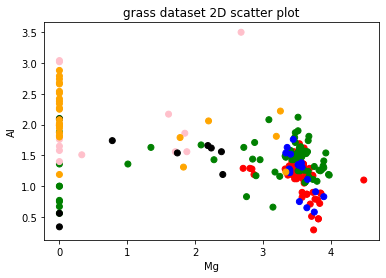

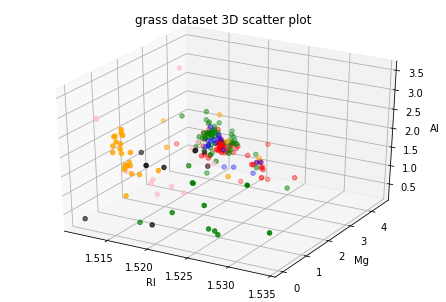

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 標準化器を作成
# standardizer = StandardScaler()
# features = standardizer.fit_transform(X)

ri = X["RI"] # sepal length (cm)
mg = X["Mg"] # petal length (cm)
al = X["Al"] # petal width (cm)
color = ["", "red", "green", "blue", "", "pink", "black", "orange"] # 各品種で色分け

# 2次元散布図
plt.scatter(mg, al, c=[color[x] for x in y])
plt.title("grass dataset 2D scatter plot")
plt.xlabel("Mg")
plt.ylabel("Al")

# 3次元散布図
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ri, mg, al, c=[color[x] for x in y])

ax.set_title("grass dataset 3D scatter plot")
ax.set_xlabel("RI")
ax.set_ylabel("Mg")
ax.set_zlabel("Al")

Text(0.5, 0, 'Al')

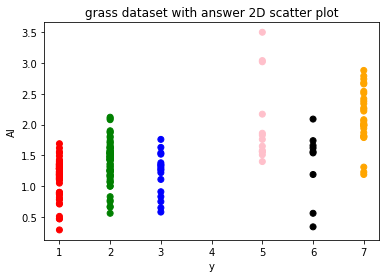

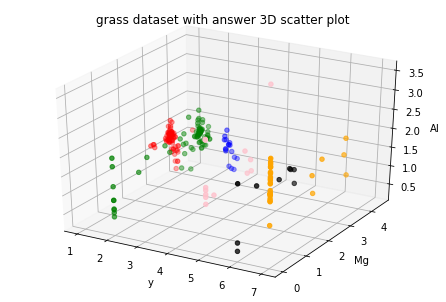

In [ ]:
# 2次元散布図
plt.scatter(y, al, c=[color[x] for x in y])
plt.title("grass dataset with answer 2D scatter plot")
plt.xlabel("y")
plt.ylabel("Al")

# 3次元散布図
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(y, mg, al, c=[color[x] for x in y])

ax.set_title("grass dataset with answer 3D scatter plot")
ax.set_xlabel("y")
ax.set_ylabel("Mg")
ax.set_zlabel("Al")

## **Titanic版**
同じことをTitanicでもやってみた

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('train.csv')

# pandas-profilingの結果をhtml形式で出力
# profile = ProfileReport(df)
# profile.to_file(outputfile="myoutputfile.html")

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [15]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

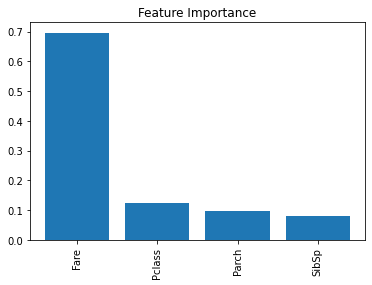

mean: 0.6801675977653634


In [16]:
y = df["Survived"]
X = df.drop(columns=["PassengerId", "Age", "Cabin", "Embarked", "Name", "Ticket", "Sex", "Survived"])
print("mean:",rf_accuracy(X, y, graph=True))

In [17]:
### 学習データとテストデータを生成する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print("====標準化なし====")
train_predict(X_train, X_test, y_train, y_test)

print("\n====標準化なし+クラスタ特徴量====")
### クラスタIDの追加
# kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(X_train, y_train)
kmf_hint = KMeansFeaturizer(k=20, target_scale=5, random_state=seed).fit(X_train, y_train)

X_train, X_test = add_cluster_id(kmf_hint, X_train, X_test, y_train, y_test)

train_predict(X_train, X_test, y_train, y_test)

====標準化なし====
0.7151 LogisticRegression
0.6872 kNN
0.7654 RBF SVM
0.7190 Random Forest
0.7318 Boosted Trees

====標準化なし+クラスタ特徴量====
0.7207 LogisticRegression
0.6704 kNN
0.7709 RBF SVM
0.7291 Random Forest
0.7263 Boosted Trees
